In [1]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
source_name='3C 279'
ra=194.046527
dec=-5.789314
radius=10.
Tstart='2003-03-15T00:00:00'
Tstop='2018-03-15T00:00:00'
E1_keV=30.
E2_keV=100.
host='www.astro.unige.ch/cdci/astrooda/dispatch-data'
rebin=10 # minimal significance in energy bin, for spectral plotting

In [3]:
#try: input = raw_input
#except NameError: pass
#token=input() # token for restricted access server
#cookies=dict(_oauth2_proxy=token)
#disp=DispatcherAPI(host=host)

In [4]:
disp=DispatcherAPI(host=host)

In [5]:
import requests
url="https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/"
def queryxtime(**args):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius)+'&min_good_isgri=1000'
    print(url+params)
    return requests.get(url+params).json()

In [6]:
scwlist=queryxtime()
m=len(scwlist)
pointings_osa10=[]
pointings_osa11=[]
for i in range(m):
    if scwlist[i][-2:]=='10':
        if(int(scwlist[i][:4])<1626):
            pointings_osa10.append(scwlist[i]+'.001')
        else:
            pointings_osa11.append(scwlist[i]+'.001')
#else:
#    pointings=np.genfromtxt('scws_3C279_isgri_10deg.txt', dtype='str')
m_osa10=len(pointings_osa10)
m_osa11=len(pointings_osa11)

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2003-03-15T00:00:00/2018-03-15T00:00:00?&ra=194.046527&dec=-5.789314&radius=10.0&min_good_isgri=1000


In [7]:
def chunk_swc_list(lst, size):
    _l = [lst[x:x+size] for x in range(0, len (lst), size)]
    for ID,_ in enumerate(_l):
        _l[ID]=','.join(_)
       
    return _l

In [8]:
scw_lists_osa10=chunk_swc_list(pointings_osa10, 50)
scw_lists_osa11=chunk_swc_list(pointings_osa11, 50)


In [9]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists_osa10[0],
                      E1_keV=E1_keV,
                      E2_keV=E2_keV,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=3.5,
                      product_type='Real')

007700160010.001,007700170010.001,007700180010.001,007700190010.001,007700200010.001,007700210010.001,007700220010.001,007700230010.001,007700240010.001,007700250010.001,007700260010.001,007700270010.001,007700280010.001,007700290010.001,007700300010.001,007700310010.001,007700320010.001,007700330010.001,007700340010.001,007700350010.001,007700360010.001,007700370010.001,007700380010.001,007700390010.001,007700400010.001,007700410010.001,007700460010.001,007700470010.001,007700480010.001,007700490010.001,007700500010.001,007700510010.001,007700520010.001,007700530010.001,007700540010.001,007700550010.001,007700560010.001,007700570010.001,007700580010.001,007700590010.001,007700600010.001,007700660010.001,007700670010.001,007800020010.001,007800030010.001,007800040010.001,007800050010.001,007800060010.001,007800070010.001,007800080010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 007700160010.001,007700170010.

In [10]:
data.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str18,float64,float64,float64,int64,int64,int64,float64
1,3C 273,12.098819732666016,187.2660675048828,2.045917510986328,-32768,2,0,0.0002800000074785203
30,IGR J12391-1612,4.082015037536621,189.77621459960938,-16.179750442504883,-32768,2,0,0.00016999999934341758
50,NGC 4593,13.66150951385498,189.91522216796875,-5.358253479003906,-32768,2,0,0.0002800000074785203
112,SWIFT J1238.6+0928,4.295688629150391,189.67724609375,9.474955558776855,-32768,1,0,0.07566666603088379


In [11]:
FLAG=0
torm=[]
for ID,n in enumerate(data.dispatcher_catalog_1.table['src_names']):
    if(n[0:3]=='NEW'):
        torm.append(ID)
    if(n==source_name):
        FLAG=1
data.dispatcher_catalog_1.table.remove_rows(torm)
nrows=len(data.dispatcher_catalog_1.table['src_names'])

In [12]:
if FLAG==0:
    data.dispatcher_catalog_1.table.add_row((0,'3C 279',0,ra,dec,0,2,0,0))


In [13]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [14]:
spectrum_results=[]
for i in range(len(scw_lists_osa10)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        scw_list=scw_lists_osa10[i],
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    spectrum_results.append(data)

0
007700160010.001,007700170010.001,007700180010.001,007700190010.001,007700200010.001,007700210010.001,007700220010.001,007700230010.001,007700240010.001,007700250010.001,007700260010.001,007700270010.001,007700280010.001,007700290010.001,007700300010.001,007700310010.001,007700320010.001,007700330010.001,007700340010.001,007700350010.001,007700360010.001,007700370010.001,007700380010.001,007700390010.001,007700400010.001,007700410010.001,007700460010.001,007700470010.001,007700480010.001,007700490010.001,007700500010.001,007700510010.001,007700520010.001,007700530010.001,007700540010.001,007700550010.001,007700560010.001,007700570010.001,007700580010.001,007700590010.001,007700600010.001,007700660010.001,007700670010.001,007800020010.001,007800030010.001,007800040010.001,007800050010.001,007800060010.001,007800070010.001,007800080010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 007700160010.001,00770017001

In [15]:
d=spectrum_results[0]
for ID,s in enumerate(d._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)
                                             

3 4 5


In [16]:
d=spectrum_results[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
print(len(rate))
for k in range(len(scw_lists_osa10)):
    d=spectrum_results[k]
    spec=d._p_list[ID_spec].data_unit[1].data
    arf=d._p_list[ID_arf].data_unit[1].data
    rmf=d._p_list[ID_rmf].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    print(k,expos)
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate)):
    if err[i]>0.:
        rate[i]=rate[i]/err[i]
        err[i]=1./sqrt(err[i])
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1.))
print('Total exposure:',tot_expos)

62
0 115628.4045003584
1 90360.35488457941
2 63730.90624156105
3 29342.9147952279
4 39597.96617770581
5 51870.4162015074
6 66761.2060621785
7 86139.60335365975
8 88811.26375878944
9 70265.73119716468
10 52742.58180900001
11 78028.85336425966
12 43830.06116397513
13 61258.60279913733
14 73039.32527144144
15 74318.5803063479
16 14567.31698580724
17 112537.7243930548
18 7002.11709562756
19 109481.4624207095
20 110902.4258233258
21 12024.0962724554
Total exposure: 1452241.914877874


/pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [17]:
print(rate)
print(err)

[ 0.         -0.01911088 -0.00474805 -0.00866921  0.02785969  0.00503991
  0.00459076  0.01800008  0.01536572  0.00929408  0.01863755  0.00983922
  0.01099933  0.01118167  0.02972144  0.01231032  0.01300915  0.01717788
  0.0314928   0.02534482  0.02182063  0.02933005  0.01923623  0.01767028
  0.02084129  0.02093466  0.01656587  0.00358998  0.01418334  0.00636991
  0.00343488  0.00305288  0.01400681  0.02062134  0.00850974  0.0188839
  0.0139104   0.0135616   0.01258732  0.0045604  -0.00377914  0.0090971
  0.00195718 -0.00091074 -0.00239978  0.00140563  0.00361399  0.00384719
 -0.00574529 -0.00728063 -0.00085991  0.00367518  0.00101125  0.00616219
  0.0039162  -0.00034443  0.00135788 -0.00320276 -0.00359471 -0.01083006
  0.00553673 -0.00270132]
[0.         0.06959551 0.03435365 0.02053951 0.01423448 0.01091227
 0.008916   0.00765228 0.00693573 0.00646697 0.00617271 0.00587696
 0.00564936 0.00540274 0.00695679 0.00599685 0.00523827 0.00479522
 0.00617981 0.00563032 0.00534151 0.00519347 

In [18]:
d._p_list[ID_spec].data_unit[1].data['RATE']=rate
d._p_list[ID_spec].data_unit[1].data['STAT_ERR']=err
d._p_list[ID_rmf].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf].data_unit[1].data['SPECRESP']=specresp

In [19]:
name=source_name.replace(" ", "")
specname=name+'_spectrum_osa10.fits'
arfname=name+'_arf_osa10.fits.gz'
rmfname=name+'_rmf_osa10.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)

In [20]:
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
hdul.close()

In [21]:
!./spectrum_fit_osa10.sh $name $rebin

Creating a $HOME/.xspec directory for you

		XSPEC version: 12.10.1f
	Build Date/Time: Tue Apr 21 20:29:57 2020

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data 3C279_spectrum_osa10.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: 3C279_spectrum_osa10.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.109e-01 +/- 9.047e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 1.452e+06 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response 3C279_rmf_osa10.fits.gz
Response successfully loaded.
XSPEC12>arf 3C279_arf_osa10.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     6 cha

In [22]:
spectrum_results1=[]
for i in range(len(scw_lists_osa11)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        scw_list=scw_lists_osa11[i],
                        query_type='Real',
                        osa_version='OSA11.0',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    spectrum_results1.append(data)

0
169500140010.001,169500150010.001,169500210010.001,169500220010.001,169500230010.001,169500240010.001,169500250010.001,169500260010.001,169500270010.001,169900840010.001,169900850010.001,175400370010.001,176000060010.001,176100050010.001,176200040010.001,176200050010.001,176200450010.001,176300030010.001,176300040010.001,176400060010.001,176400460010.001,176400470010.001,176500360010.001,176500450010.001,176500460010.001,182000220010.001,182000310010.001,182100250010.001,182100340010.001,182200220010.001,182200230010.001,182200240010.001,182200320010.001,182300600010.001,182400030010.001,182400430010.001,182400440010.001,182800300010.001,182800400010.001,183200120010.001,183200130010.001,183200190010.001,183200200010.001,183200210010.001,183200220010.001,183200230010.001,183200240010.001,183200250010.001,183200290010.001,183200300010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 169500140010.001,16950015001

In [23]:
d=spectrum_results1[0]
for ID,s in enumerate(d._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)



3 4 5


In [24]:
d=spectrum_results1[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
print(len(rate))
for k in range(len(scw_lists_osa11)):
    d=spectrum_results1[k]
    spec=d._p_list[ID_spec].data_unit[1].data
    arf=d._p_list[ID_arf].data_unit[1].data
    rmf=d._p_list[ID_rmf].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    print(k,expos)
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate)):
    if err[i]>0.:
        rate[i]=rate[i]/err[i]
        err[i]=1./sqrt(err[i])
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1.))
print('Total exposure:',tot_expos)

256
0 26026.8547870585
1 8087.67341090079
Total exposure: 34114.52819795929


/pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [25]:
d._p_list[ID_spec].data_unit[1].data['RATE']=rate
d._p_list[ID_spec].data_unit[1].data['STAT_ERR']=err
d._p_list[ID_rmf].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf].data_unit[1].data['SPECRESP']=specresp

In [26]:
name=source_name.replace(" ", "")
specname=name+'_spectrum_osa11.fits'
arfname=name+'_arf_osa11.fits.gz'
rmfname=name+'_rmf_osa11.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)

In [27]:
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
hdul.close()

In [28]:
!./spectrum_fit_osa11.sh $name $rebin


		XSPEC version: 12.10.1f
	Build Date/Time: Tue Apr 21 20:29:57 2020

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data 3C279_spectrum_osa11.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: 3C279_spectrum_osa11.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.216e-01 +/- 1.530e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-256
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 3.411e+04 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response 3C279_rmf_osa11.fits.gz
Response successfully loaded.
XSPEC12>arf 3C279_arf_osa11.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:    25 channels ignored from  source number 1
XSPEC

In [29]:
data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        T1='2015-06-15T15:56:45',
                        T2='2015-06-16T06:13:10',
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        #detection_threshold=5.0,
                        radius=15.,
                        product_type='Real',
                        selected_catalog=api_cat)

- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2015-06-15T15:56:45
T2 2015-06-16T06:13:10
query_type Real
osa_version OSA10.2
RA 194.046527
DEC -5.789314
radius 15.0
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[1, 30, 50, 112, 0], ["3C 273", "IGR J12391-1612", "NGC 4593", "SWIFT J1238.6+0928", "3C 279"], [12.098819732666016, 4.082015037536621, 13.66150951385498, 4.295688629150391, 0.0], [187.2660675048828, 189.77621459960938, 189.91522216796875, 189.67724609375, 194.046527], [2.045917510986328, -16.179750442504883, -5.358253479003906, 9.474955558776855, -5.789314], [-32768, -32768, -32768, -32768, 0], [2, 2, 2, 1, 2], [0, 0, 0, 0, 0], [0.0002800000074785203, 0.00016999999934341758, 0.0002800000074785203, 0.07566666603088379, 0.0]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_I

In [30]:
data._p_list[0].write_fits_file(name+'_flare_spectrum_osa10.fits')
data._p_list[1].write_fits_file(name+'_flare_arf_osa10.fits.gz')
data._p_list[2].write_fits_file(name+'_flare_rmf_osa10.fits.gz')

In [38]:
name1=name+'_flare'
!./spectrum_fit_osa10.sh $name1 5


		XSPEC version: 12.10.1f
	Build Date/Time: Tue Apr 21 20:29:57 2020

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data 3C279_flare_spectrum_osa10.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: 3C279_flare_spectrum_osa10.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -nan      +/- -nan     
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 2.135e+04 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response 3C279_flare_rmf_osa10.fits.gz
Response successfully loaded.
XSPEC12>arf 3C279_flare_arf_osa10.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     6 channels ignored from

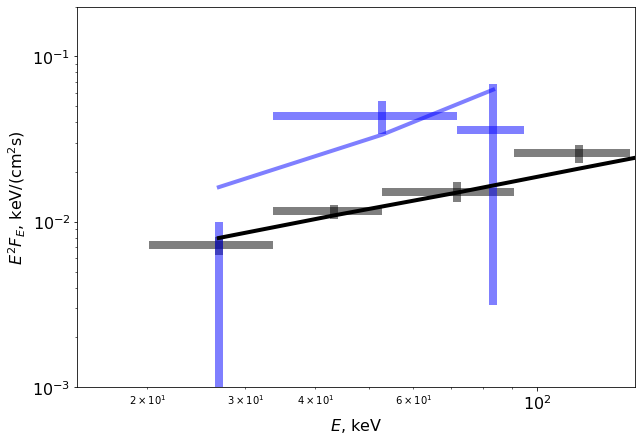

In [41]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt(name+'_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=0.5)
plt.plot(en,mo,color='black',linewidth=4)


spectrum=np.genfromtxt(name+'_flare_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='blue',alpha=0.5)
plt.plot(en,mo,color='blue',linewidth=4,alpha=0.5)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-3,0.2)
plt.xlim(15,150)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.savefig(name+'_spectra.pdf',format='pdf',dpi=100)




In [40]:
spectrum_3C279=name+'_spectra.pdf'